In [1]:
!pip install distance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 3.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16258 sha256=dd61f619d88d16ffcecee803eb450d2d6ad09eb040c70ca181b32464b0010ea7
  Stored in directory: /root/.cache/pip/wheels/e8/bb/de/f71bf63559ea9a921059a5405806f7ff6ed612a9231c4a9309
Successfully built distance


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import re
import string
import distance

In [3]:
df = pd.read_csv("/kaggle/input/quora-question-pairs/train.csv.zip")
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
# Removing Null Values
df.isna().sum()
df.dropna(inplace = True)

In [5]:
# Removing Duplicated Values
df.duplicated().sum()

0

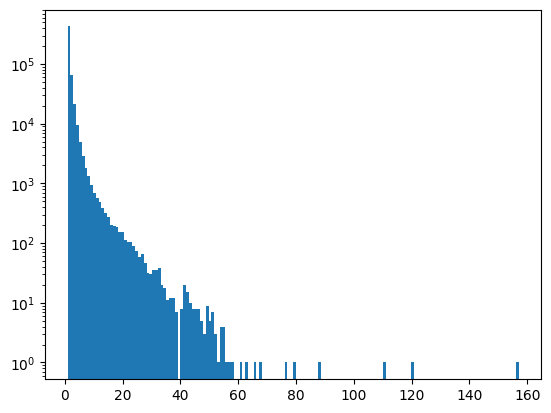

In [5]:
# Duplicate question pairs among all questions
freq_count = pd.Series(list(df['qid1']) + list(df['qid2'])).value_counts().values
plt.hist(freq_count, bins = 160)
plt.yscale('log')
plt.show()

In [8]:
new_df = df.sample(30000).loc[:, ['question1', 'question2', 'is_duplicate']]
new_questions_df = new_df[['question1', 'question2']]
new_df.head()

,question1,question2,is_duplicate
337374,What are the advantages and disadvantages of b...,What are the advantages of brain drain?,1
122571,My 11-year-old daughter is getting stares when...,I have a 10 year old daughter who refuses to g...,0
105276,How did the US arrive at 110 volts and much of...,How much maximum volts is needed to be used on...,0
70661,In what ways do people go blind?,Do most people go blind in their lifetime?,0
31790,How do women feel when they get very horny?,What should you do when you get turned down by...,0


In [10]:
all_questions = list(new_questions_df["question1"]) + list(new_questions_df["question2"])

In [11]:
cv = CountVectorizer(max_features = 3000)
vectorized = cv.fit_transform(all_questions).toarray()
vectorized.shape

(60000, 3000)

In [23]:
q1, q2 = np.vsplit(vectorized, 2)

temp_df1 = pd.DataFrame(q1, index = new_questions_df.index)
temp_df2 = pd.DataFrame(q2, index = new_questions_df.index)

temp_df = pd.concat([temp_df1, temp_df2], axis = 1)
temp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
337374,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
122571,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
105276,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70661,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31790,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,0,0,0,0,0,0


In [24]:
temp_df.shape

(30000, 6000)

In [25]:
temp_df['is_duplicate'] = new_df['is_duplicate']
X_train, X_test, y_train, y_test = train_test_split(temp_df.drop(columns = ['is_duplicate']), temp_df['is_duplicate'], test_size = 0.2, random_state = 42)

In [30]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7456666666666667

---

In [6]:
new_df = df.sample(50000).loc[:, ['question1', 'question2', 'is_duplicate']]
new_questions_df = new_df[['question1', 'question2']]
new_df.head()

,question1,question2,is_duplicate
157980,Which Xbox 360 games also play on Xbox one?,Can you play all Xbox 360 games with Xbox One?,0
80140,How can I learn better in school/ How can I ge...,How can I study to get better grades?,1
198239,What kind of rules/boundaries should I establi...,What kind of music should I listen to in order...,0
231548,What career can I choose after the completion ...,What career should I pursue after completing m...,0
45907,What is past life regression?,What is it like to have a past life regression...,0


In [7]:
# All Preprocessing
def preprocessing(q: str) -> str:
    # Step 1 -: Lowercasing and removing whitespaces
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent ')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')

    # The pattern '[math]' appears around 900 times in the dataset.
    q = q.replace('[math]', '')

    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)

    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")

    # Removing HTML tags
    pattern = re.compile('<.*?>')
    q = pattern.sub(r'', q)

    # Removing Punctuations
    q = q.translate(str.maketrans('', '', string.punctuation))

    # Stemming
    stemmer = PorterStemmer()
    q = ' '.join([stemmer.stem(word) for word in q.split()])

    return q

In [8]:
preprocessing('What is the step by step guide to invest in share market in india?')

'what is the step by step guid to invest in share market in india'

In [9]:
new_questions_df['question1'] = new_questions_df['question1'].apply(preprocessing)
new_questions_df['question2'] = new_questions_df['question2'].apply(preprocessing)

/tmp/ipykernel_30/4286267399.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_questions_df['question1'] = new_questions_df['question1'].apply(preprocessing)
/tmp/ipykernel_30/4286267399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_questions_df['question2'] = new_questions_df['question2'].apply(preprocessing)


In [10]:
new_questions_df.head()

,question1,question2
157980,which xbox 360 game also play on xbox one,can you play all xbox 360 game with xbox one
80140,how can i learn better in school how can i get...,how can i studi to get better grade
198239,what kind of rulesboundari should i establish ...,what kind of music should i listen to in order...
231548,what career can i choos after the complet of b...,what career should i pursu after complet my gr...
45907,what is past life regress,what is it like to have a past life regress ex...


📌 Creating Basic Features

In [11]:
# Length of question(Numbers of letters)
new_questions_df['q1_len'] = new_questions_df['question1'].str.len() 
new_questions_df['q2_len'] = new_questions_df['question2'].str.len()

In [12]:
# Number of words in all questions
new_questions_df['q1_num_words'] = new_questions_df['question1'].apply(lambda row: len(row.split(" ")))
new_questions_df['q2_num_words'] = new_questions_df['question2'].apply(lambda row: len(row.split(" ")))
new_questions_df.head()

,question1,question2,q1_len,q2_len,q1_num_words,q2_num_words
168439,what are some good word to describ snow,what are the word that describ hate,39,35,8,7
26746,what are some of the best nonfict and fiction ...,what are the best book of all time,50,34,10,8
77562,adam dangelo what is the best strategi to seed...,what is the most interest internet market stra...,102,91,18,16
195982,ancient man schizophren,what is the rout of tran asian highway,23,38,3,8
109823,what are the main part of the digest system ho...,what are the major part of the digest system,64,44,13,9


In [13]:
# number of common words in both the question
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

new_questions_df['word_common'] = new_questions_df.apply(common_words, axis=1)
new_questions_df.head()

,question1,question2,q1_len,q2_len,q1_num_words,q2_num_words,word_common
168439,what are some good word to describ snow,what are the word that describ hate,39,35,8,7,4
26746,what are some of the best nonfict and fiction ...,what are the best book of all time,50,34,10,8,6
77562,adam dangelo what is the best strategi to seed...,what is the most interest internet market stra...,102,91,18,16,8
195982,ancient man schizophren,what is the rout of tran asian highway,23,38,3,8,0
109823,what are the main part of the digest system ho...,what are the major part of the digest system,64,44,13,9,7


In [14]:
# Total unique words in both q1 and q2
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

new_questions_df['word_total'] = new_questions_df.apply(total_words, axis=1)
new_questions_df.head()

,question1,question2,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total
168439,what are some good word to describ snow,what are the word that describ hate,39,35,8,7,4,15
26746,what are some of the best nonfict and fiction ...,what are the best book of all time,50,34,10,8,6,18
77562,adam dangelo what is the best strategi to seed...,what is the most interest internet market stra...,102,91,18,16,8,33
195982,ancient man schizophren,what is the rout of tran asian highway,23,38,3,8,0,11
109823,what are the main part of the digest system ho...,what are the major part of the digest system,64,44,13,9,7,20


In [15]:
# percent word sharing by both the questions
new_questions_df['word_share'] = round(new_questions_df['word_common']/new_questions_df['word_total'],2)
new_questions_df.head()

,question1,question2,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
168439,what are some good word to describ snow,what are the word that describ hate,39,35,8,7,4,15,0.27
26746,what are some of the best nonfict and fiction ...,what are the best book of all time,50,34,10,8,6,18,0.33
77562,adam dangelo what is the best strategi to seed...,what is the most interest internet market stra...,102,91,18,16,8,33,0.24
195982,ancient man schizophren,what is the rout of tran asian highway,23,38,3,8,0,11,0.00
109823,what are the main part of the digest system ho...,what are the major part of the digest system,64,44,13,9,7,20,0.35


📌 Creating Advance Features

In [16]:
def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [17]:
token_features = new_questions_df.apply(fetch_token_features, axis=1)

new_questions_df["cwc_min"]       = list(map(lambda x: x[0], token_features))
new_questions_df["cwc_max"]       = list(map(lambda x: x[1], token_features))
new_questions_df["csc_min"]       = list(map(lambda x: x[2], token_features))
new_questions_df["csc_max"]       = list(map(lambda x: x[3], token_features))
new_questions_df["ctc_min"]       = list(map(lambda x: x[4], token_features))
new_questions_df["ctc_max"]       = list(map(lambda x: x[5], token_features))
new_questions_df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
new_questions_df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [18]:
new_questions_df.head()

,question1,question2,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
168439,what are some good word to describ snow,what are the word that describ hate,39,35,8,7,4,15,0.27,0.666644,0.499988,0.499988,0.499988,0.571420,0.499994,0.0,1.0
26746,what are some of the best nonfict and fiction ...,what are the best book of all time,50,34,10,8,6,18,0.33,0.666644,0.499988,0.799984,0.666656,0.749991,0.599994,0.0,1.0
77562,adam dangelo what is the best strategi to seed...,what is the most interest internet market stra...,102,91,18,16,8,33,0.24,0.374995,0.249998,0.999980,0.624992,0.499997,0.444442,0.0,0.0
195982,ancient man schizophren,what is the rout of tran asian highway,23,38,3,8,0,11,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
109823,what are the main part of the digest system ho...,what are the major part of the digest system,64,44,13,9,7,20,0.35,0.749981,0.599988,0.999975,0.571420,0.777769,0.538457,0.0,1.0


In [19]:
def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    if(len(strs) != 0):
        length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    else:
        length_features[2] = 0 / (min(len(q1), len(q2)) + 1)
    
    return length_features

In [20]:
length_features = new_questions_df.apply(fetch_length_features, axis=1)

new_questions_df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
new_questions_df['mean_len'] = list(map(lambda x: x[1], length_features))
new_questions_df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [21]:
new_questions_df.head()

,question1,question2,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio
168439,what are some good word to describ snow,what are the word that describ hate,39,35,8,7,4,15,0.27,0.666644,0.499988,0.499988,0.499988,0.571420,0.499994,0.0,1.0,1.0,7.5,0.250000
26746,what are some of the best nonfict and fiction ...,what are the best book of all time,50,34,10,8,6,18,0.33,0.666644,0.499988,0.799984,0.666656,0.749991,0.599994,0.0,1.0,2.0,9.0,0.285714
77562,adam dangelo what is the best strategi to seed...,what is the most interest internet market stra...,102,91,18,16,8,33,0.24,0.374995,0.249998,0.999980,0.624992,0.499997,0.444442,0.0,0.0,2.0,17.0,0.184783
195982,ancient man schizophren,what is the rout of tran asian highway,23,38,3,8,0,11,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,5.0,5.5,0.125000
109823,what are the main part of the digest system ho...,what are the major part of the digest system,64,44,13,9,7,20,0.35,0.749981,0.599988,0.999975,0.571420,0.777769,0.538457,0.0,1.0,4.0,11.0,0.577778


In [22]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

/opt/conda/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [23]:
fuzzy_features = new_df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
new_questions_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
new_questions_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
new_questions_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
new_questions_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

new_questions_df.head()

,question1,question2,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
168439,what are some good word to describ snow,what are the word that describ hate,39,35,8,7,4,15,0.27,0.666644,...,0.499994,0.0,1.0,1.0,7.5,0.250000,72,74,69,77
26746,what are some of the best nonfict and fiction ...,what are the best book of all time,50,34,10,8,6,18,0.33,0.666644,...,0.599994,0.0,1.0,2.0,9.0,0.285714,51,61,64,85
77562,adam dangelo what is the best strategi to seed...,what is the most interest internet market stra...,102,91,18,16,8,33,0.24,0.374995,...,0.444442,0.0,0.0,2.0,17.0,0.184783,40,47,55,58
195982,ancient man schizophren,what is the rout of tran asian highway,23,38,3,8,0,11,0.00,0.000000,...,0.000000,0.0,0.0,5.0,5.5,0.125000,28,31,34,34
109823,what are the main part of the digest system ho...,what are the major part of the digest system,64,44,13,9,7,20,0.35,0.749981,...,0.538457,0.0,1.0,4.0,11.0,0.577778,77,94,78,93


In [24]:
new_questions_df.shape

(50000, 24)

In [25]:
all_questions = list(new_questions_df['question1']) + list(new_questions_df['question2'])

In [26]:
cv = CountVectorizer(max_features = 3000)
encoded = cv.fit_transform(all_questions).toarray()
encoded

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [27]:
question1, question2 = np.vsplit(encoded, 2)
temp1 = pd.DataFrame(question1, index = new_questions_df.index)
temp2 = pd.DataFrame(question2, index = new_questions_df.index)

final_df = pd.concat([new_questions_df, temp1, temp2], axis = 1)

In [28]:
final_df.shape

(50000, 6024)

In [29]:
final_df.drop(columns = ['question1', 'question2'], inplace = True)
final_df.head()

,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,csc_min,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
168439,39,35,8,7,4,15,0.27,0.666644,0.499988,0.499988,...,0,0,0,0,0,0,0,0,0,0
26746,50,34,10,8,6,18,0.33,0.666644,0.499988,0.799984,...,0,0,0,0,0,0,0,0,0,0
77562,102,91,18,16,8,33,0.24,0.374995,0.249998,0.999980,...,0,0,0,0,0,0,0,0,0,0
195982,23,38,3,8,0,11,0.00,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
109823,64,44,13,9,7,20,0.35,0.749981,0.599988,0.999975,...,0,0,0,0,0,0,0,0,0,0


In [30]:
final_df.columns = final_df.columns.astype(str)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(final_df, new_df['is_duplicate'], test_size = 0.2, random_state = 42)

In [44]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7902

In [50]:
rf2 = RandomForestClassifier(
    n_estimators = 500,
    oob_score = True, 
    n_jobs = -1,
    random_state = 42
)
rf2.fit(X_train, y_train)
y_pred = rf2.predict(X_test)
accuracy_score(y_test, y_pred)

0.791

In [52]:
rf2.oob_score_

0.79985

In [53]:
accuracy_score(y_train, rf2.predict(X_train))

1.0

In [55]:
rf3 = RandomForestClassifier(
    n_estimators = 100,
    max_depth = 5,
    oob_score = True, 
    n_jobs = -1,
    random_state = 42
)
rf3.fit(X_train, y_train)
y_pred = rf3.predict(X_test)
accuracy_score(y_test, y_pred)

0.63

In [32]:
# Applying Deep Learning
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM

In [33]:
model = Sequential()
model.add(Input(shape = (X_train.shape[1],)))
model.add(Dense(units = 100, activation = 'relu'))
model.add(Dense(units = 50, activation = 'relu'))
model.add(Dense(units = 25, activation = 'relu'))
model.add(Dense(units = 10, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │       602,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 608,896 (2.32 MB)

 Trainable params: 608,896 (2.32 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [35]:
model.fit(X_train, y_train, epochs = 25, validation_data = [X_test, y_test])

Epoch 1/25


I0000 00:00:1732187109.070441     114 service.cc:145] XLA service 0x7d56940057a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732187109.070494     114 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732187109.070498     114 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  95/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6302 - loss: 0.6230

I0000 00:00:1732187110.622523     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6836 - loss: 0.5519 - val_accuracy: 0.7558 - val_loss: 0.4741
Epoch 2/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7733 - loss: 0.4455 - val_accuracy: 0.7630 - val_loss: 0.4720
Epoch 3/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7900 - loss: 0.4161 - val_accuracy: 0.7669 - val_loss: 0.4671
Epoch 4/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8049 - loss: 0.3913 - val_accuracy: 0.7738 - val_loss: 0.4663
Epoch 5/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8134 - loss: 0.3746 - val_accuracy: 0.7678 - val_loss: 0.4749
Epoch 6/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8216 - loss: 0.3625 - val_accuracy: 0.7717 - val_loss: 0.4702
Epoch 7/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8305 - loss: 0.3462 - val_accuracy: 0.7512 - val_loss: 0.4761
Epoch 8/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8395 - loss: 0.3331 - val_accurac

---

In [206]:
deep_learn_df = new_questions_df[['question1', 'question2']]
deep_learn_df.head()

,question1,question2
157980,which xbox 360 game also play on xbox one,can you play all xbox 360 game with xbox one
80140,how can i learn better in school how can i get...,how can i studi to get better grade
198239,what kind of rulesboundari should i establish ...,what kind of music should i listen to in order...
231548,what career can i choos after the complet of b...,what career should i pursu after complet my gr...
45907,what is past life regress,what is it like to have a past life regress ex...


In [207]:
# Tokenize all documents
from tensorflow.keras.preprocessing.text import Tokenizer

In [208]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(deep_learn_df['question1']) + list(deep_learn_df['question2']))

# tokenizer.word_index.values()  MAx -> 28513

In [209]:
question1 = tokenizer.texts_to_sequences(deep_learn_df['question1'])
question2 = tokenizer.texts_to_sequences(deep_learn_df['question2'])

In [ ]:
max_len = 0
for question in question1 + question2:
    max_len = max(max_len, len(question))
max_len

In [171]:
# Applying Padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

question1_padded = pad_sequences(question1, maxlen = max_len, padding = 'post')
question2_padded = pad_sequences(question2, maxlen = max_len, padding = 'post')

In [186]:
question1_padded.shape

(50000, 248)

In [187]:
question2_padded.shape

(50000, 248)

In [150]:
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM

input1 = Input(shape = (max_len,))
input2 = Input(shape = (max_len,))

In [151]:
embedding = Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 100) 

emb1 = embedding(input1)
emb2 = embedding(input2)

In [152]:
from tensorflow.keras.layers import Bidirectional
lstm_l1 = Bidirectional(LSTM(units = 150))

lstm_out1 = lstm_l1(emb1)
lstm_out2 = lstm_l1(emb2)

In [153]:
from tensorflow.keras.layers import concatenate

merged = concatenate([lstm_out1, lstm_out2])

In [154]:
dense = Dense(150, activation='relu')(merged)
output = Dense(1, activation='sigmoid')(dense)

In [155]:
from tensorflow.keras.models import Model
model = Model(inputs=[input1, input2], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [156]:
model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 248)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_19      │ (None, 248)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, 248, 100)  │  2,863,200 │ input_layer_18[0… │
│ (Embedding)         │                   │            │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 300)       │    301,200 │ embedding_10[0][… │
│ (Bidirectional)     │                   │            │ embedding_10[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 600)       │          0 │ bidirectional_4[… │
│ (Concatenate)       │                   │            │ bidirectional_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 150)       │     90,150 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │        151 │ dense_16[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,254,701 (12.42 MB)

 Trainable params: 3,254,701 (12.42 MB)

 Non-trainable params: 0 (0.00 B)

In [158]:
# 4. Train the Model
labels = np.array(new_df['is_duplicate'])
model.fit([question1_padded, question2_padded], labels, batch_size=32, epochs=10, validation_split = 0.2)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 56s 45ms/step - accuracy: 0.7606 - loss: 0.4958 - val_accuracy: 0.7662 - val_loss: 0.4845
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - accuracy: 0.8178 - loss: 0.3931 - val_accuracy: 0.7686 - val_loss: 0.4991
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - accuracy: 0.8685 - loss: 0.3036 - val_accuracy: 0.7682 - val_loss: 0.5105
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - accuracy: 0.9300 - loss: 0.1676 - val_accuracy: 0.7432 - val_loss: 0.7119
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - accuracy: 0.9512 - loss: 0.1239 - val_accuracy: 0.7477 - val_loss: 0.8778
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - accuracy: 0.9601 - loss: 0.1009 - val_accuracy: 0.7362 - val_loss: 0.9823
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - accuracy: 0.9673 - loss: 0.0862 - val_accuracy: 0.7420 - val_loss: 1.1628
Epoch 9/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - accuracy: 0.9767 -

In [215]:
from sklearn.metrics import accuracy_score
def prediction(question1, question2):
    # Basic Preprocessing
    question1 = preprocessing(question1)
    question2 = preprocessing(question2)

    # Tockenizing
    question1_tokens = tokenizer.texts_to_sequences(pd.Series(question1))
    question2_tokens = tokenizer.texts_to_sequences(pd.Series(question2))

    # Padding
    question1_padded = pad_sequences(question1_tokens, maxlen = max_len, padding = 'post')
    question2_padded = pad_sequences(question2_tokens, maxlen = max_len, padding = 'post')

    # Model Prediction
    y_pred = model.predict([question1_padded, question2_padded])
    return y_pred

In [220]:
question1 = "What is the name of India prime minister"
question2 = "Who is the prime minister of India"
prediction(deep_learn_df.loc[157980, 'question1'], deep_learn_df.loc[157980, 'question2'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array([[0.00044476]], dtype=float32)

In [221]:
new_df.loc[157980, 'is_duplicate']

0

In [217]:
prediction(question1, question2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


array([[0.01347322]], dtype=float32)

In [218]:
prediction("What is the color of sky", "Does sky is blue")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array([[0.0029132]], dtype=float32)

This Deep Learning model is overfitting